In [7]:
# import pandas as pd
# import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Boosting Algorithms
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [3]:
df = pd.read_csv("Food_Delivery_Times.csv")
df.drop('Order_ID' ,axis = 1, inplace= True)
df

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68
...,...,...,...,...,...,...,...,...
995,8.50,Clear,High,Evening,Car,13,3.0,54
996,16.28,Rainy,Low,Morning,Scooter,8,9.0,71
997,15.62,Snowy,High,Evening,Scooter,26,2.0,81
998,14.17,Clear,Low,Afternoon,Bike,8,0.0,55


In [4]:
df.describe()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,970.000000,1000.000000
mean,10.059970,16.982000,4.579381,56.732000
std,5.696656,7.204553,2.914394,22.070915
min,0.590000,5.000000,0.000000,8.000000
25%,5.105000,11.000000,2.000000,41.000000
50%,10.190000,17.000000,5.000000,55.500000
75%,15.017500,23.000000,7.000000,71.000000
max,19.990000,29.000000,9.000000,153.000000


Data cleaning

In [5]:
df1 = df.copy()
df1.isnull().sum()

Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [8]:
# using simple imputer fill it with most frequent
imputer = SimpleImputer(strategy='most_frequent')
col_name = ['Weather' ,'Traffic_Level' , 'Time_of_Day']
df1[col_name] = imputer.fit_transform(df[col_name])
# Fill with mean 
df1 ['Courier_Experience_yrs']= df1['Courier_Experience_yrs'].fillna(df1['Courier_Experience_yrs'].mean())


In [9]:
df1.isnull().sum()

Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

EDA -Exploratory Data Analysis

In [34]:
# Observing data
df1.sample(10)

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
854,18.89,Rainy,Medium,Morning,Scooter,22,1.0,74
633,2.92,Windy,High,Afternoon,Bike,24,4.0,48
180,9.54,Rainy,Medium,Evening,Scooter,11,5.0,47
848,6.54,Clear,Medium,Night,Bike,10,7.0,39
586,5.32,Rainy,Low,Afternoon,Scooter,27,2.0,48
910,0.59,Clear,Low,Afternoon,Bike,21,0.0,27
696,1.27,Foggy,High,Afternoon,Bike,25,9.0,46
64,2.85,Clear,Low,Morning,Scooter,26,0.0,38
446,10.88,Snowy,Low,Afternoon,Car,13,3.0,52
5,19.40,Clear,Low,Evening,Scooter,8,9.0,57


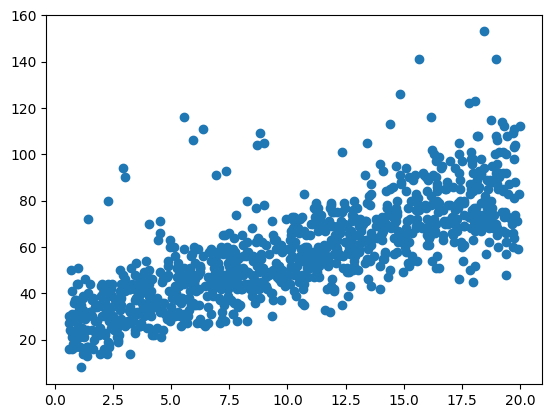

In [10]:
# what is the correlation between distance and delivery Ans : Linear 
plt.scatter(x='Distance_km', y='Delivery_Time_min', data=df)


<BarContainer object of 1000 artists>

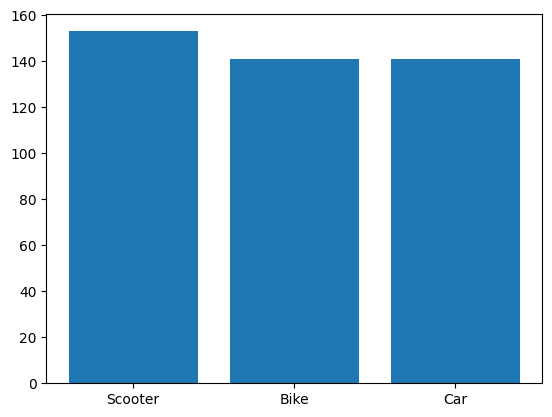

In [11]:
plt.bar("Vehicle_Type" , 'Delivery_Time_min' , data=df)

In [14]:

X = df1.drop("Delivery_Time_min", axis=1)
y = df1["Delivery_Time_min"]

# Identify categorical columns
cat_cols = ["Weather", "Traffic_Level", "Time_of_Day", "Vehicle_Type"]
encoder_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoder_dict[col] = le 
# One-hot encode for XGBoost
X_xgb = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Train-test split
X_train_xgb, X_test_xgb, y_train, y_test = train_test_split(
    X_xgb, y, test_size=0.2, random_state=42
)

# For LightGBM & CatBoost (they can handle categorical directly)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# Models
# ==============================
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        random_state=42,
        verbose=-1
    ),
    "CatBoost": CatBoostRegressor(
        n_estimators=500,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        verbose=0
    ),
}

# ==============================
# Train & Evaluate
# ==============================
results = {}

# XGBoost (needs one-hot encoding)
models["XGBoost"].fit(X_train_xgb, y_train)
preds = models["XGBoost"].predict(X_test_xgb)
results["XGBoost"] = {
    "MAE": mean_absolute_error(y_test, preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "R2": r2_score(y_test, preds),
}

# LightGBM
models["LightGBM"].fit(X_train, y_train, categorical_feature=cat_cols)
preds = models["LightGBM"].predict(X_test)
results["LightGBM"] = {
    "MAE": mean_absolute_error(y_test, preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "R2": r2_score(y_test, preds),
}

# CatBoost
models["CatBoost"].fit(X_train, y_train, cat_features=cat_cols)
preds = models["CatBoost"].predict(X_test)
results["CatBoost"] = {
    "MAE": mean_absolute_error(y_test, preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
    "R2": r2_score(y_test, preds),
}

# ==============================
# Results
# ==============================
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df.sort_values("RMSE"))


Model Performance Comparison:
               MAE       RMSE        R2
CatBoost  6.160077   9.269132  0.808319
LightGBM  7.188081   9.750262  0.787903
XGBoost   7.258230  10.262898  0.765014


In [20]:
sample_data = pd.DataFrame([{
    "Distance_km": 8.5,
    "Weather": "Rainy",
    "Traffic_Level": "Low",
    "Time_of_Day": "Morning",
    "Vehicle_Type": "Bike",
    "Preparation_Time_min": 5,
    "Courier_Experience_yrs": 5
}])
# Encode categorical columns with the same encoders
for col, le in encoder_dict.items():
    sample_data[col] = le.transform(sample_data[col])
# Use your trained CatBoost model
predicted_time = models["CatBoost"].predict(sample_data)[0]

print(f"Predicted Delivery Time: {predicted_time:.2f} minutes")


Predicted Delivery Time: 36.13 minutes
